# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


During this first *challenge* of the *Advanced Machine Learning Course*, you will experiment with the development of a data analysis pipeline based upon various techniques seen during the lectures so far: some **unsupervised** (*e.g.* *PCA*, *kernel-PCA*) and some others **supervised** (*e.g.* *kernel SVM* and *Artificial Neural Networks* for classification).

In [1]:
## Import Libraries
import numpy as np

from tqdm.auto import trange

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms


import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.decomposition import PCA, KernelPCA
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, accuracy_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

## Used to save data into files
import pickle as pkl
import os

# Used to represent neural networks
from torchviz import make_dot

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The dataset

The dataset of interest for the *challenge* will be [*FashionMNIST*](https://github.com/zalandoresearch/fashion-mnist), an *MNIST*-like dataset of grayscale images of fashion items. Originally developed by Zalando Research in 2017 as a harder (yet *drop-in* compatible) replacement for the original *MNIST* dataset, it has been used in several papers and competitions since then.

Remember to consider the *dataset* mentioned below as the **training set** offered by *FashionMNIST*. Use the *test set* only at the end, to evaluate the overall accuracy of the pipeline!

In [2]:
## Import train and test dataset, scale them and convert them to data loaders
BATCH_SIZE = 64


train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = False)

test_loader = DataLoader(dataset = test_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = False)

In [3]:
## Randomly select 10000 images from the training and test dataset

subset_size = 10000

## set a seed for randperm
th.manual_seed(42)

idx = th.randperm(len(train_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

train_subset_loader = DataLoader(train_dataset, sampler=sampler)

idx = th.randperm(len(test_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

test_subset_loader = DataLoader(train_dataset, sampler=sampler)

del(idx)
del(sampler)

In [4]:
## Convert the images and their labels to numpy arrays and reshape them to vectors

labels_train = []
train_subset = []
for batch in train_subset_loader:
    data, labels = batch
    
    train_subset.append(data.numpy().reshape(1, -1))
    labels_train.append(labels.numpy())

train_subset_scaled = np.array(train_subset).reshape(subset_size, -1)
labels_train = np.array(labels_train)

In [5]:
test_subset = []
labels_test = []

for batch in test_subset_loader:
    data, labels = batch
    
    test_subset.append(data.numpy().reshape(1, -1))
    labels_test.append(labels.numpy())

test_subset_scaled = np.array(test_subset).reshape(subset_size, -1)
labels_test = np.array(labels_test)

In [6]:
# Creating dictionary of labels for better understanding
description = {0: "T-shirt/top", 
               1: "Trouser", 
               2: "Pullover", 
               3: "Dress", 
               4: "Coat", 
               5: "Sandal", 
               6: "Shirt", 
               7: "Sneaker", 
               8: "Bag", 
               9: "Ankle boot"}

ticks = list(description.keys())
tick_labels = list(description.values())

In [7]:
## Defining functions to save and load data from pickle files

def save_data(data, filename):
    if not os.path.exists(filename):
        with open(filename, "wb") as f:
            pkl.dump(data, f)

def load_data(filename):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            data = pkl.load(f)
    return data

## Section 1: Understanding data geometry

Load the dataset in the most suitable form for the tasks that follow. Then, perform the following steps, with the goal of developing a geometric understanding of the dataset:

1. Perform a (linear) *PCA* on the dataset, and plot the first two (or three!) principal components along with the true label. Comment on data separation.

2. Perform a *kernel-PCA* on the dataset with a Gaussian kernel, and plot the first two (or three!) principal components along with the true label. Try to tune the dispersion parameter of the kernel to obtain a good separation of the data. Comment.

3. Perform another *kernel-PCA* on the dataset with another kernel of your own choice, and plot the first two (or three!) principal components along with the true label. Try to tune the degree of the polynomial kernel to obtain a good separation of the data. Comment.

Whenever suitable, try to complement your analysis with some graphs!

**IMPORTANT NOTICE**: As some of you have reported, performing *kernel PCA* on the entire *FashionMNIST* dataset can be memory- and time- demanding (as it scales with the square of the number of datapoints!). In case you want to reduce such requirements, you can either:
  - Reduce the number of datapoints on which to perform *kPCA*, *e.g.* by slicing the randomly-shuffled dataset *(most effective!)*;
  - Reduce the size of the images in the dataset (*i.e.* by dropping even/odd rows/columns, or performing local pooling) *(somehow effective: you may want to try it if you do not have access to powerful compute, but still enjoy challenges!)*.

In [8]:
# Choose the color map for the plots
cmap = plt.get_cmap('viridis', 10)

In [9]:
## Perform linear PCA

model = PCA(n_components = 3)
data_pca_linear = model.fit_transform(train_subset_scaled)

del(model)

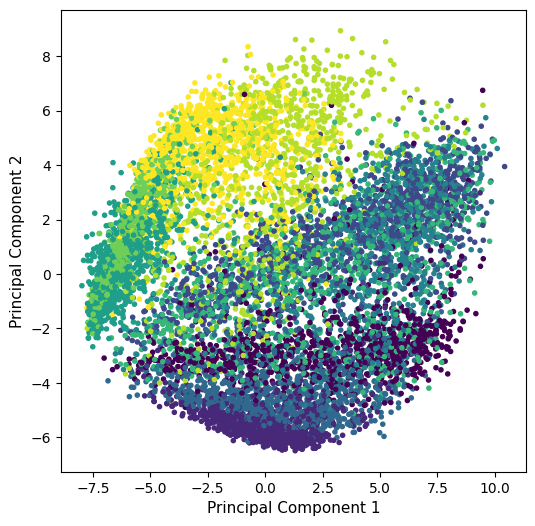

In [10]:
# Plot the first two principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], c = labels_train, marker='.', cmap = cmap)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)


# Uncomment to plot the colorbar
# cb = plt.colorbar(p)
# cb.set_ticks(ticks)
# cb.set_ticklabels(tick_labels)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

del(p)
# plt.savefig("Report/pca_linear_2comps.png")

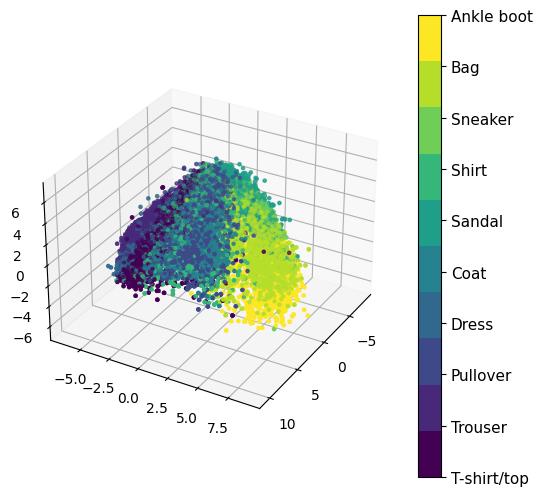

In [11]:
# Plot the first two principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], data_pca_linear[:, 2], c = labels_train, marker='.', cmap=cmap)
ax.view_init(elev=30, azim=30)


# Uncomment to show colorbar
cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)
# cb.ax.set_title('Class', fontsize=11)
del(cb)

del(fig)
del(ax)
del(p)


# plt.savefig("Report/pca_linear_3comps.png")

#### Comment
The data does not seem to be well separated, so finding the right hyperplane for classification will be hard.

### 1.2: Perform kernel PCA

In [12]:
# Perform kernel pca using the RBF kernel
    
kernel_pca = KernelPCA(kernel="rbf", n_components = 3)
data_pca_rbf = kernel_pca.fit_transform(train_subset_scaled)

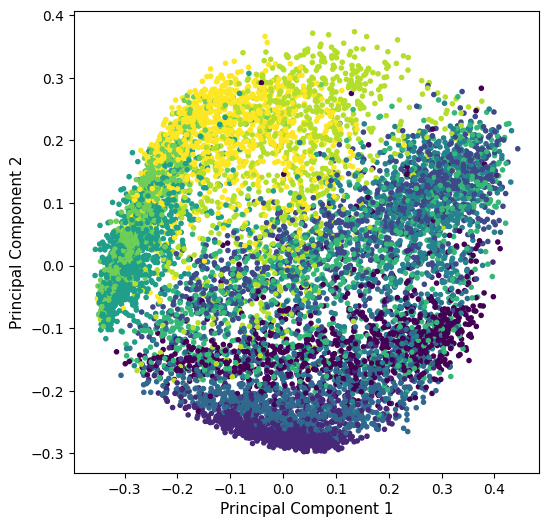

In [13]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], c = labels_train, marker='.', cmap=cmap)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

del(p)
del(fig)
# plt.savefig("Report/pca_rbf_2comps.png")

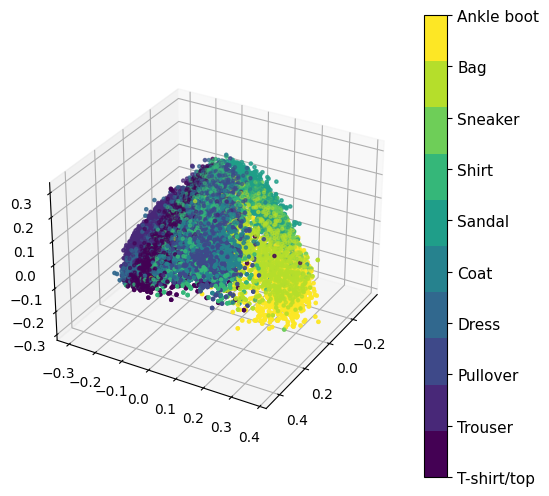

In [14]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], data_pca_rbf[:, 2], c = labels_train, marker='.', cmap=cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)
del(cb)

ax.view_init(elev=30, azim=30)

del(fig)
del(ax)
del(p)

# plt.savefig("Report/pca_rbf_3comps.png")

### Perform parameter tuning

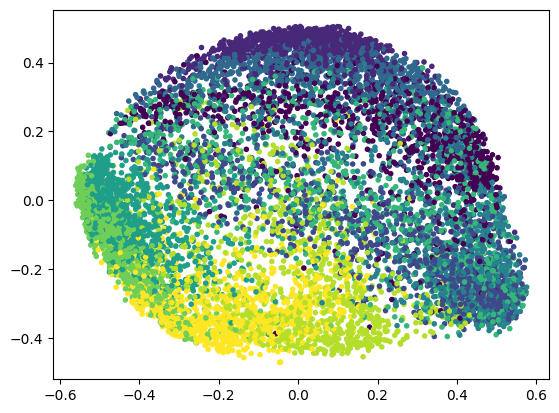

In [15]:
kernel_pca = KernelPCA(kernel = "rbf", n_components = 3, gamma = 5 / 784)
data_pca_rbf = kernel_pca.fit_transform(train_subset_scaled)

plt.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], c = labels_train, marker='.', cmap=cmap)

In [16]:
# Perform kernel pca using the RBF kernel, tune gamma to separate clusters
    
gamma = np.array([(1/10)*(1/784), 1/784, 10 * (1/784)])

data_pca_rbf = np.ndarray((10000, 3, len(gamma)))

for i in range(len(gamma)):
    kernel_pca = KernelPCA(kernel = "rbf", n_components = 3, gamma = gamma[i])
    data_pca_rbf[:, :, i] = kernel_pca.fit_transform(train_subset_scaled)

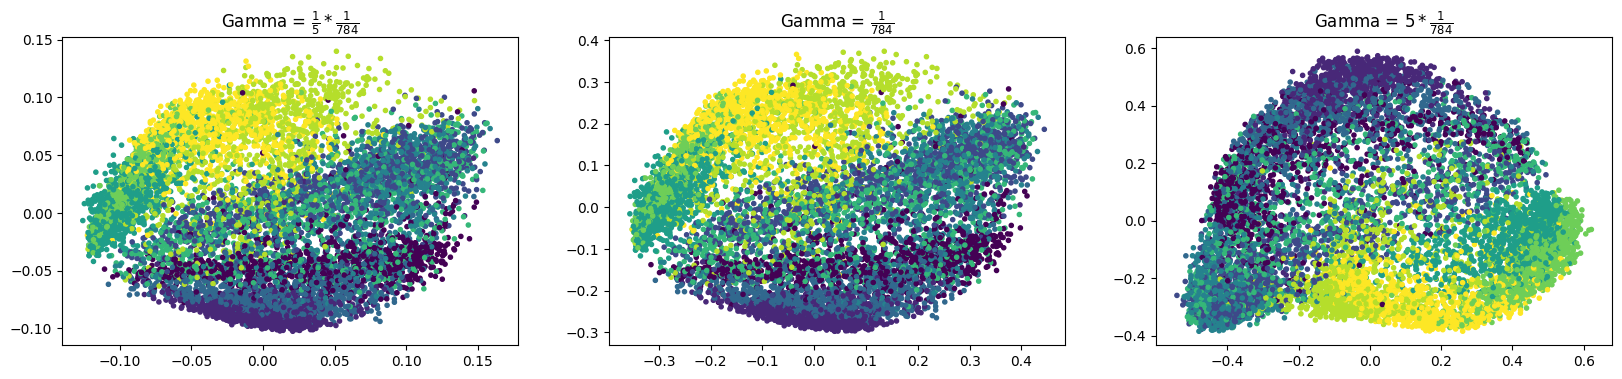

In [17]:
# scatterplot for different gammas

gammas = ["$\\frac{1}{5} * \\frac{1}{784}$", "$\\frac{1}{784}$", "$5 * \\frac{1}{784}$"]
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

for i, ax in enumerate(axs.flat):
    p = ax.scatter(data_pca_rbf[:, 0, i], data_pca_rbf[:, 1, i], c = labels_train, marker='.', cmap=cmap)
    ax.set_title('Gamma = ' + gammas[i])

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)

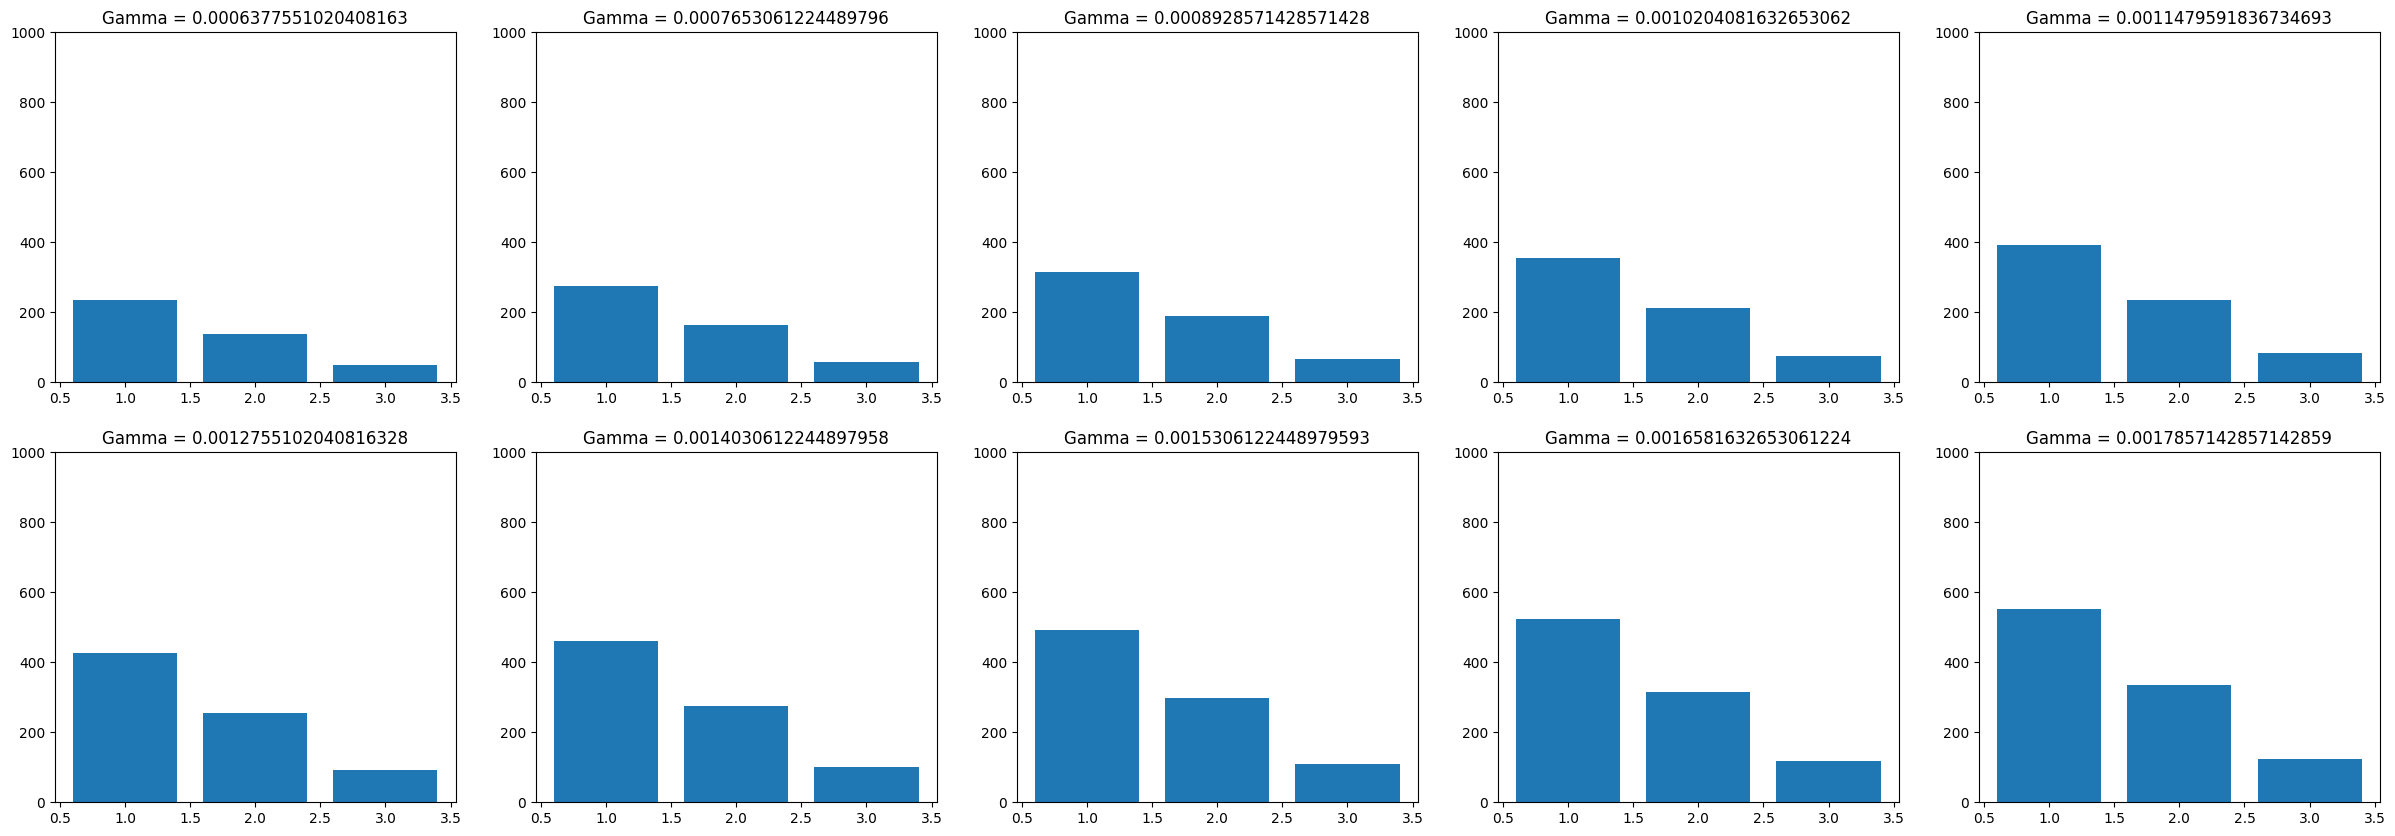

In [18]:
## Choose the range of the parameter gamma
gammas = np.arange(1/784 - 5 * (1/784) * (1/10), 1/784 + 5 * (1/784) * (1/10), (1/784) * (1/10))

## Extract eigenvalues
n_components = 3
eigenvalues_rbf = np.empty((len(gammas), n_components))

for i in range(len(gammas)):
    kernel_pca = KernelPCA(kernel="rbf", n_components = n_components, gamma = gammas[i])
    eigenvalues_rbf[i] = kernel_pca.fit(train_subset_scaled).eigenvalues_



fig, axs = plt.subplots(2, 5, figsize=(30, 10))
# Create 10 random plots
for i, ax in enumerate(axs.flat):
    x = np.arange(1, len(eigenvalues_rbf[i, :]) + 1, 1)
    # Plot the data on the corresponding axis
    ax.bar(x, eigenvalues_rbf[i, :])
    ax.set_ylim(0, 1000)
    # ax.set_xlabel('Component')
    # ax.set_ylabel('Eigenvalue')
    ax.set_title('Gamma = ' + str(gammas[i]))

### 1.3 Perform kPCA using another kernel

In [19]:
# Try kernel poly

kernel_pca = KernelPCA(kernel = "poly", n_components = 3)

data_pca_poly = kernel_pca.fit_transform(train_subset_scaled)

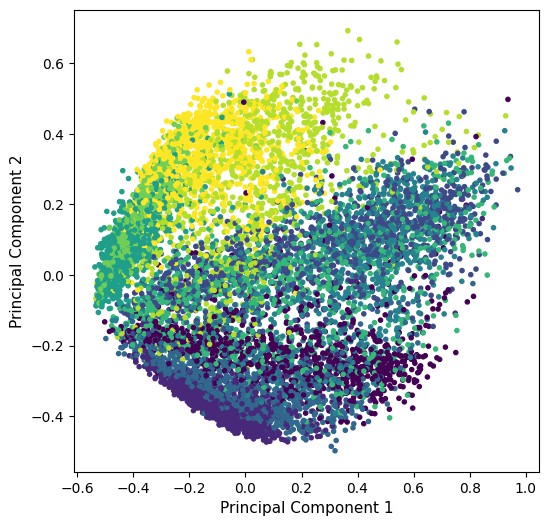

In [20]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], c = labels_train, marker='.', cmap = cmap)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

del(p)
del(fig)

# plt.savefig("Report/pca_poly_2comps.png")

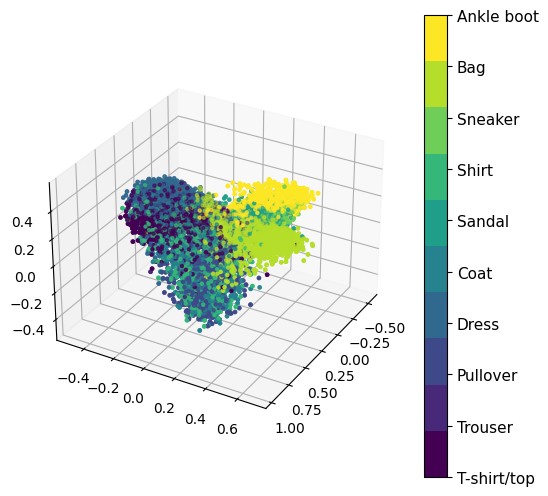

In [21]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], data_pca_poly[:, 2], c = labels_train, marker='.', cmap=cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)
del(cb)

ax.view_init(elev=30, azim=30)

# plt.savefig("Report/pca_poly_3comps.png")

In [22]:
# Try kernel sigmoid
kernel_pca = KernelPCA(kernel="sigmoid", n_components = 10)

data_pca_sigmoid = kernel_pca.fit_transform(train_subset_scaled)

eigenvalues_sigmoid = kernel_pca.eigenvalues_

Text(0, 0.5, 'Principal Component 2')

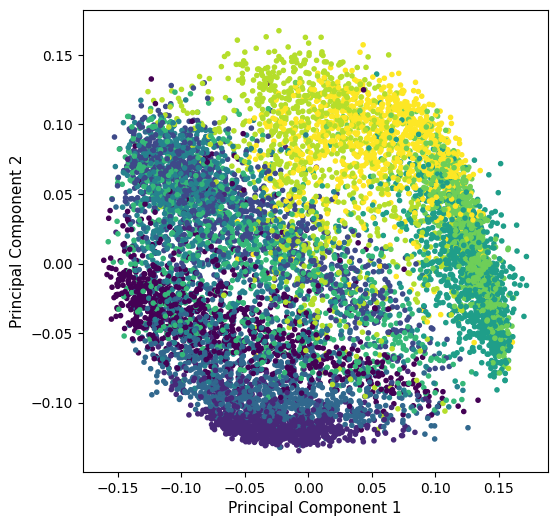

In [23]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels_train, marker='.', cmap = cmap)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# plt.savefig("Report/pca_sigmoid_2comps.png")

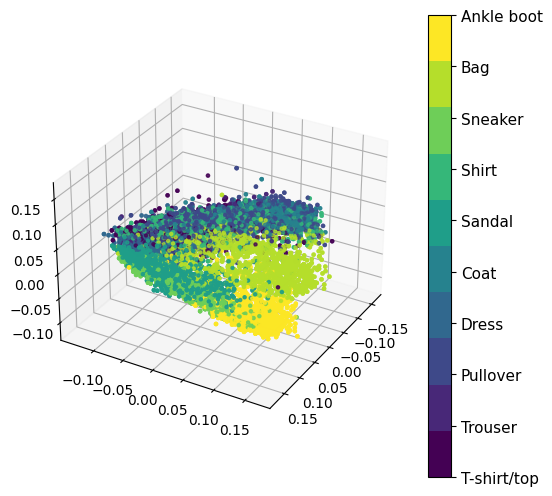

In [24]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], data_pca_sigmoid[:, 2], c = labels_train, marker='.', cmap = cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)
del(cb)

ax.view_init(elev=30, azim=30)

# plt.savefig("Report/pca_sigmoid_3comps.png")

In [25]:
# Measure separation of the clusters using the Davies-Bouldin score
# The lower the better

# DB_score = []

# DB_score.append(davies_bouldin_score(data_pca_linear, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_rbf, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_poly, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels_train.reshape(-1)))

# print(f"DB score: linear: {DB_score[0]:.4f} | rbf: {DB_score[1]:.4f} | poly: {DB_score[2]:.4f} | sigmoid: {DB_score[3]:.4f}")

## Section 2: Bridging *unsupervised* and *supervised*

Choose one of the results obtained in the previous section (you should choose the one better explaining data geometry), and ignore the true labels. Then, perform the following steps:

1. Considering only the first $10$ components of the *(kernel-)PCA* and try to assign $10$ labels to the resulting datapoints. Choose the approach you deem most suitable. Comment on the results, by considering:
    
    a. How well does the label-assignment just performed reflect the true labels?

    b. Does the number of components used ($10$) reflect the actual *knee-* or *gap-* *point* of the spectrum associated to the principal components?

Whenever suitable, try to complement your analysis with some graphs!

In [26]:
# Perform clustering with different techniques

labels_Kmeans = KMeans(n_clusters = 10, n_init=10).fit(data_pca_sigmoid).labels_

labels_Spectral = SpectralClustering(n_clusters = 10, affinity='nearest_neighbors').fit(data_pca_sigmoid).labels_

labels_Gaussian = GaussianMixture(n_components = 10).fit(data_pca_sigmoid).predict(data_pca_sigmoid)

labels = np.array([labels_train.reshape(subset_size), labels_Kmeans, labels_Spectral, labels_Gaussian])

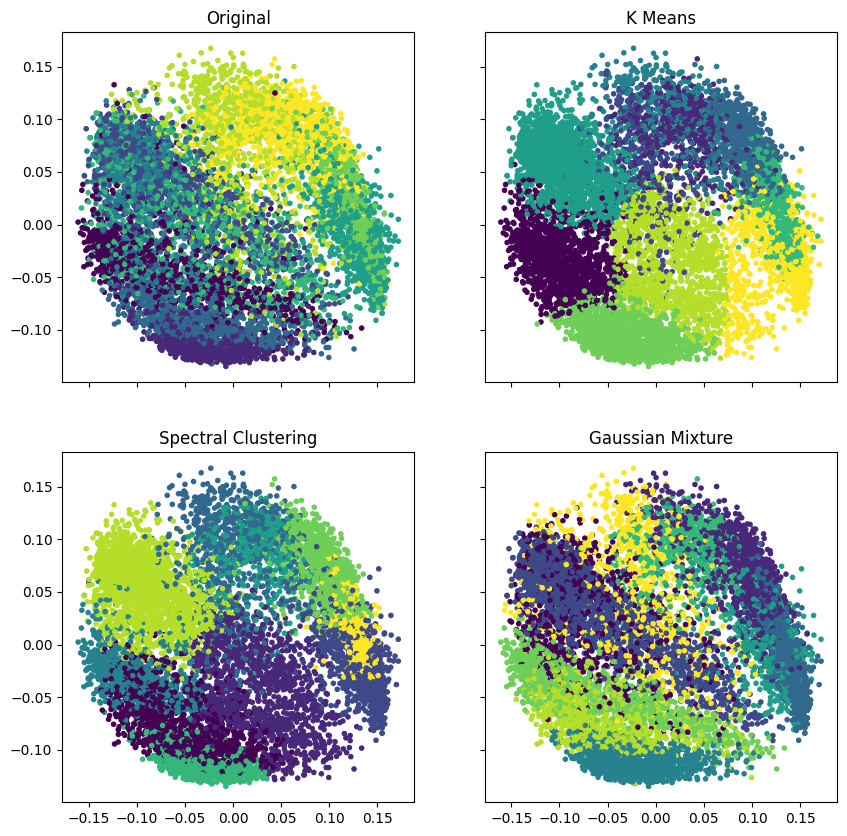

In [27]:
# Plot the results and compare them with the original clustering

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

title_names = ["Original", "K Means", "Spectral Clustering", "Gaussian Mixture"]

for ax, i in zip(axs.flat, range(4)):
    ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels[i, :], marker='.')
    ax.set_title(title_names[i])

del(fig)
del(axs)   
# plt.savefig("Report/unsupervised_clustering.png")

In [28]:
# Calculate Adjusted Rand Index

ARI = np.empty(3)

for i in range(3):
    ARI[i] = adjusted_rand_score(labels[0, :], labels[i + 1, :])
    print(f"Adjusted Rand Index for {title_names[i + 1]}: {ARI[i]:.4f}")
    
# del(title_names)
del(ARI)

Adjusted Rand Index for K Means: 0.3627
Adjusted Rand Index for Spectral Clustering: 0.4340
Adjusted Rand Index for Gaussian Mixture: 0.3980


In [29]:
# Measure separation of the clusters using the Davies-Bouldin score
# The lower the better

# DB_score = []

# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[0, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[1, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[2, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[3, :].reshape(-1)))

# print(f"DB score: original: {DB_score[0]:.4f} | KMeans: {DB_score[1]:.4f} | Spectral: {DB_score[2]:.4f} | Gaussian: {DB_score[3]:.4f}")

#### a
As we can see, label assignment performed poorly. This, probably, because the clusters are very close to each other and not clearly separated.

#### b
As we can see from the plot below, there is a clear elbow on the third component. This suggests that 10 does not reflect the actual knee point of the spectrum of the principal components.

Text(0, 0.5, 'Eigenvalue')

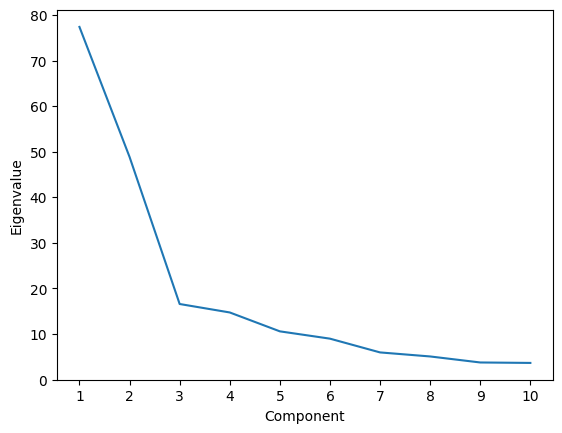

In [30]:
# Plot the eigenvalues obtained with the sigmoid method

plt.plot(np.arange(1, len(eigenvalues_sigmoid) + 1, 1), eigenvalues_sigmoid)

plt.xticks(np.arange(1, 11, 1))

plt.xlabel('Component')
plt.ylabel('Eigenvalue')

# plt.savefig("Report/eigenvalues_sigmoid.png")

## Section 3: (Supervised) classification

Consider the dataset composed of the original images, with the label assigned in the previous section (regardless of its actual match with the true label!). Then, define and learn a classifier that can predict the label of a new image. Specifically:

1. Learn a *kernel-SVM* on the data/label pairs. The choice of the kernel and its hyperparameters is up to your experimentation and time availability. Comment on your choices and results.

2. Learn a *fully-connected NN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results.

3. Learn a *CNN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability. Comment on the results with special respect to the FCN architecture.

In [31]:
# Split the dataset into training and test set

x_train, x_test, y_train, y_test = train_test_split(train_subset_scaled, labels_Spectral, test_size=0.3, random_state=42)

#### 3.1: kernel SVM with different kernels

In [32]:
# Linear kernel

classifier = SVC(kernel = "linear").fit(x_train, y_train)

label_predict_SVC_linear = classifier.predict(x_test)

acc_linear = accuracy_score(y_test, label_predict_SVC_linear)

In [33]:
# RBF kernel

classifier = SVC(kernel = "rbf").fit(x_train, y_train)

label_predict_SVC_rbf = classifier.predict(x_test)

acc_rbf = accuracy_score(y_test, label_predict_SVC_rbf)

In [34]:
# Polynomial kernel

classifier = SVC(kernel = "poly").fit(x_train, y_train)

label_predict_SVC_rbf = classifier.predict(x_test)

acc_poly = accuracy_score(y_test, label_predict_SVC_rbf)

In [35]:
# Sigmoid kernel

classifier = SVC(kernel = "sigmoid").fit(x_train, y_train)

label_predict_SVC_sigmoid = classifier.predict(x_test)

acc_sigmoid = accuracy_score(y_test, label_predict_SVC_sigmoid)

In [36]:
print(f"Accuracy: linear: {acc_linear:.4f} | rbf: {acc_rbf:.4f} | poly: {acc_poly:.4f} | sigmoid: {acc_sigmoid:.4f}")

Accuracy: linear: 0.9657 | rbf: 0.9733 | poly: 0.9613 | sigmoid: 0.4327


#### 3.2: Fully Connected NN

In [37]:
## Pass data to tensors

data_train = TensorDataset(Tensor(x_train.reshape(-1, 1, 28, 28)), th.tensor(y_train, dtype = th.long))
data_train_loader = DataLoader(dataset = data_train, batch_size = 64, shuffle = False)



data_test = TensorDataset(Tensor(x_test.reshape(-1, 1, 28, 28)), th.tensor(y_test, dtype = th.long))
data_test_loader = DataLoader(dataset = data_test, batch_size = 64, shuffle = False)

In [38]:
# Define some functions needed to calculate the accuracy

def get_batch_accuracy(logit, target):
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, criterion, test_loader, device):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc

In [39]:
# Define function used to train the model

def train_model(epochs, train_loader, criterion, optimizer, device, model):
    _batch_losses = []
    
    _model = model
    for _ in trange(epochs):
        _model = _model.train()

        # Actual (batch-wise) training step
        for _, (_images, _labels) in enumerate(train_loader):
            _images = _images.to(device)
            _labels = _labels.to(device)

            _logits = _model(_images)
            _loss = criterion(_logits, _labels)
            _batch_losses.append(_loss.item())  # Store the loss for plotting, per batch

            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()
    
    return _model

In [40]:
## Define function used to get labels
def get_predicted_labels(model, test_data, device):
    test_data_tensor = th.tensor(test_data.reshape(-1, 1, 28, 28))

    model = model.eval()

    labels = []
    with th.no_grad():
        for i in range(test_data_tensor.shape[0]):
            data = test_data_tensor[i].reshape(1, 1, 28, 28)
            pred = model(data.to(device))
            labels.append(th.argmax(pred).item())
            
    return np.array(labels)

In [41]:
# Define the Fully Connected Neural Network

class FullyConnectedNN_1layer(nn.Module):
    def __init__(self, image_dim, n_classes):
        
        super(FullyConnectedNN_1layer, self).__init__()
        
        self.fc1 = nn.Linear(in_features = image_dim,
                            out_features = n_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        # x = F.relu(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [42]:
# Choose device
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [43]:
# Train the model and calculate accuracy on the train set

trained_acc_FC_1l = []
labels_FC_1l = np.ndarray((3000, 20))

# Choose if tou want to save or load the model, True for load False for save
load_model = True

if load_model:
    # Load the already trained model
    loaded_models = th.load('trained_models/models_ex3_FC1l_epochs.pth')
else:
    # Initialise the list of models
    models = {}
    
criterion = nn.CrossEntropyLoss()

for i in range(20):
    
    model = FullyConnectedNN_1layer(image_dim = 28 * 28, n_classes = 10).to(device)

    optimizer = th.optim.SGD(model.parameters(), lr=0.01)
    
    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

    if load_model == True:
        # Select a specific trained model
        model = model.train()
        model.load(loaded_models[f'epoch_{i + 1}'])
        
    else:
        # Train the model and save it in models
        model = model.train()
        model = train_model(epochs = i + 1,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        model = model.eval()
        models[f'epoch_{i + 1}'] = model
    
    
    model = model.eval()
            
    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
    trained_acc_FC_1l.append(trained_acc)
    
    
    labels_FC_1l[:, i] = get_predicted_labels(model = model, test_data = x_test, device = device)

    print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
    
    del(trained_acc)
    del(trained_loss)
    del(model)

if not load_model:
    # Save the trained models
    th.save(models, 'trained_models/models_ex3_FC1l_epochs.pth')
    
del(optimizer)
del(criterion)
del(untrained_acc)
del(untrained_loss)
del(i)

del(labels_FC_1l)
del(trained_acc_FC_1l)

if load_model:
    del(loaded_models)
else:
    del(models)


Untrained test loss: 2.3504, accuracy: 10.94%
Accuracy: 12.5 | Loss: 2.5927724838256836
Untrained test loss: 2.2851, accuracy: 15.62%
Accuracy: 12.5 | Loss: 2.8701043128967285
Untrained test loss: 2.3150, accuracy: 6.25%
Accuracy: 12.5 | Loss: 3.092611074447632
Untrained test loss: 2.3529, accuracy: 9.38%


Accuracy: 12.5 | Loss: 3.3525803089141846
Untrained test loss: 2.3033, accuracy: 7.81%
Accuracy: 14.0625 | Loss: 3.530118703842163
Untrained test loss: 2.1883, accuracy: 18.75%
Accuracy: 14.0625 | Loss: 3.6802687644958496
Untrained test loss: 2.3544, accuracy: 9.38%
Accuracy: 14.0625 | Loss: 3.7907040119171143
Untrained test loss: 2.4799, accuracy: 0.00%
Accuracy: 14.0625 | Loss: 3.9440510272979736
Untrained test loss: 2.2285, accuracy: 23.44%
Accuracy: 14.0625 | Loss: 4.033200740814209
Untrained test loss: 2.3102, accuracy: 1.56%
Accuracy: 14.0625 | Loss: 4.151552200317383
Untrained test loss: 2.3144, accuracy: 9.38%
Accuracy: 14.0625 | Loss: 4.230864524841309
Untrained test loss: 2.3919, accuracy: 7.81%
Accuracy: 14.0625 | Loss: 4.301891326904297
Untrained test loss: 2.4756, accuracy: 0.00%
Accuracy: 14.0625 | Loss: 4.395890712738037
Untrained test loss: 2.4444, accuracy: 4.69%
Accuracy: 14.0625 | Loss: 4.50256872177124
Untrained test loss: 2.2256, accuracy: 9.38%
Accuracy: 14.0625 |

In [44]:
abc

NameError: name 'abc' is not defined

In [47]:
th.load('trained_models/models_ex3_FC1l_epochs.pth')

{'epoch_1': OrderedDict([('fc1.weight',
               tensor([[ 1.8814e-02, -3.2914e-02, -6.3387e-03,  ...,  2.2598e-02,
                         1.2246e-02,  1.6501e-02],
                       [-3.5068e-02, -3.1795e-02, -1.0779e-02,  ..., -2.1517e-02,
                        -3.4444e-02,  1.0557e-02],
                       [ 5.0430e-05,  6.2743e-03, -1.5252e-02,  ..., -2.7011e-02,
                        -4.4139e-03, -5.6587e-03],
                       ...,
                       [ 2.1766e-02, -1.9920e-02,  3.0198e-02,  ...,  2.7489e-02,
                        -1.1496e-02,  1.4131e-02],
                       [-4.8325e-03, -3.2119e-02,  5.4372e-03,  ..., -2.8877e-02,
                        -2.0257e-02,  2.3655e-02],
                       [-1.4937e-02,  3.1835e-02, -5.5480e-03,  ..., -3.5816e-02,
                        -6.9704e-03,  2.3022e-02]])),
              ('fc1.bias',
               tensor([ 0.0522,  0.0265,  0.0214, -0.0165, -0.0131, -0.0417, -0.0196,  0.0297,
         

(50.0, 100.0)

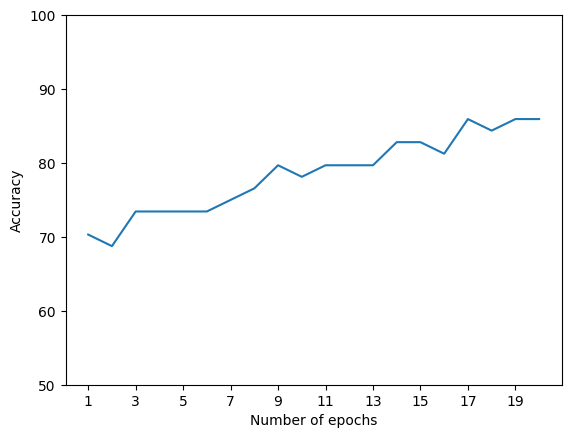

In [ ]:
# Predict labels for the test set and calculate the test accuracy

plt.plot(np.arange(1, len(trained_acc_FC_1l) + 1, 1), trained_acc_FC_1l)
plt.xticks(np.arange(1, len(trained_acc_FC_1l) + 1, 2))
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.ylim(50, 100)
# plt.savefig("Report/ex3_FCNN1l_accuracy-epochs.png")

In [ ]:
edf

NameError: name 'edf' is not defined

In [ ]:
# Try with two layers

class FullyConnectedNN_2layer(nn.Module):
    def __init__(self, image_dim, n_classes, hidden_features):
        
        super(FullyConnectedNN_2layer, self).__init__()
        
        self.fc1 = nn.Linear(in_features = image_dim,
                            out_features = hidden_features)
        
        self.fc2 = nn.Linear(in_features = hidden_features,
                             out_features = n_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        # x = F.relu(x)
        x = self.fc2(x)
        # x = F.relu(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [ ]:
# See how accuracy vary with the number of hidden neurons

trained_acc_FC_2l_neurons = []
labels_FC_2l = np.ndarray((3000, 100))

j = 0
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

# Choose if you want to save or load the model
load_model = True

if load_model:
    # Load the already trained model
    loaded_models = th.load('trained_models/models_ex3_FC2l_neurons.pth')
else:
    models = {}

for i in np.arange(50, 10050, 100):
    model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = i)
    
    model = model.to(device)
    print(f"Using device: {device}")

    optimizer = th.optim.SGD(model.parameters(), lr=0.01)
    

    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
    
    if load_model:
        model.load_state_dict(loaded_models[f'neurons_{i + 1}'])
        
    else:
        model = model.train()
        model = train_model(epochs = 8,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        model = model.eval()
        models[f'neurons_{i + 1}'] = model.state_dict()
        
    model = model.eval()

    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
    trained_acc_FC_2l_neurons.append(trained_acc)
    
    print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
    
    model = model.eval()
    labels_FC_2l[:, j] = get_predicted_labels(test_data = x_test, device=device, model = model)
    
    j += 1
    
if not load_model:
    # Save the trained models
    th.save(models, 'trained_models/models_ex3_FC2l_neurons.pth')

In [ ]:
# Plot accuracy wrt number of neurons
plt.plot(np.arange(50, 50 + 100 * len(trained_acc_FC_2l_neurons), 100), trained_acc_FC_2l_neurons)
plt.ylim((50, 100))
plt.xlabel("Number of hidden neurons")
plt.ylabel("Accuracy")
# plt.savefig("Report/ex3_FCNN2l_accuracy-neurons.png")

In [ ]:
# Test how accuracy varies depending on the number of epochs

# Define vector to keep all the accuracies, that we will plot
trained_acc_FC_2l = []

# Define an array to keep all the predicted labels
labels_FC_2l = np.ndarray((3000, 20))

j = 0

# Choose loss
criterion = nn.CrossEntropyLoss()

# Choose if you want to save or load the model
load_model = True

if load_model:
    # Load the already trained model
    loaded_models = th.load('trained_models/models_ex3_FC2l_epochs.pth')
else:
    models = {}


for i in range(20):
    model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 850)
    
    model = model.to(device)
    print(f"Using device: {device}")

    optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
    

    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
    
    if load_model:
        model.load_state_dict(loaded_models[f'epochs_{i + 1}'])
        
    else:
        
        model = model.train()
        model = train_model(epochs = i + 1,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        # model = model.train()
        # batch_losses = []
        
        # # Train the model for another epoch
        # for _, (_images, _labels) in enumerate(data_train_loader):
        #     _images = _images.to(device)
        #     _labels = _labels.to(device)

        #     _logits = model(_images)
        #     _loss = criterion(_logits, _labels)
        #     batch_losses.append(_loss.item())  # Store the loss for plotting, per batch

        #     optimizer.zero_grad()
        #     _loss.backward()
        #     optimizer.step()
        
        model = model.eval()
        models[f'epochs_{i + 1}'] = model.state_dict()
    
    model = model.eval()

    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
    trained_acc_FC_2l.append(trained_acc)
    
    print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
    
    model = model.eval()
    labels_FC_2l[:, j] = get_predicted_labels(test_data = x_test, device=device, model = model)
    
    j += 1
    
if not load_model:
    # Save the trained models
    th.save(models, 'trained_models/models_ex3_FC2l_epochs.pth')

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model

plt.plot(np.arange(1, 21, 1), trained_acc_FC_2l)
plt.xticks(np.arange(1, 21, 2))
plt.ylim((50, 100))
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

# plt.savefig("Report/ex3_FCNN2l_accuracy-epochs.png")

#### 3.3: Convolutional Neural Network

In [ ]:
class CNN_1layer(nn.Module):
    def __init__(self, n_classes, kernel_size, input_size):
        super(CNN_1layer, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._kernel = kernel_size
        
        self._dimensions = input_size
        
 
        self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
                               out_channels = self._dimensions[1],
                               kernel_size=self._kernel)
        
        self.bn1 = nn.BatchNorm2d(self._dimensions[1])
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
            
        self.pool = nn.MaxPool2d(kernel_size = self._kernel, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - self._kernel) * self._stride_inv + 1,
                                (self._dimensions[3] - self._kernel) * self._stride_inv + 1
                                ]
        
        
        self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
    
        
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = F.relu(x)
        
        x = self.pool(x)

        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        
        x = F.log_softmax(x, dim = 1)
        
        return x

In [ ]:
# Device selection
model = CNN_1layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28])

# Choose loss
criterion = nn.CrossEntropyLoss()

# Define vector to keep all the accuracies, that we will plot
trained_acc_CNN_1l = []

# Choose if you want to save or load the model
load_model = True

if load_model:
    # Load the already trained model
    loaded_models = th.load('trained_models/models_ex3_CNN1l_epochs.pth')
else:
    models = {}

for i in range(20):

    optimizer = th.optim.SGD(model.parameters(), lr = 0.01)


    model = model.to(device)

    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
    if load_model:
        model.load_state_dict(loaded_models[f'epochs_{i + 1}'])
    else:
        model = model.train()
        model = train_model(epochs = i + 1,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        model = model.eval()
        models[f'epochs_{i + 1}'] = model.state_dict()
        
    model = model.eval()

    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
    print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
    
    trained_acc_CNN_1l.append(trained_acc)

    model = model.eval()

    CNN_labels = get_predicted_labels(model = model, test_data = x_test, device = device)

if not load_model:
    # Save the trained models
    th.save(models, 'trained_models/models_ex3_CNN1l_epochs.pth')

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model

plt.plot(np.arange(1, len(trained_acc_CNN_1l) + 1, 1), trained_acc_CNN_1l)
plt.xticks(np.arange(1, len(trained_acc_CNN_1l) + 1, 2))
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.ylim(50, 100)
# plt.savefig("Report/ex3_CNN1l_accuracy-epochs.png")

In [ ]:
# Try with two layers

class CNN_2layer(nn.Module):
    def __init__(self, n_classes, kernel_size, input_size, hidden_size):
        super(CNN_2layer, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._kernel = kernel_size
        
        self._dimensions = input_size
        
 
        self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
                               out_channels = hidden_size,
                               kernel_size=self._kernel)
        
        self.bn1 = nn.BatchNorm2d(hidden_size)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
            
        self.pool = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - self._kernel) * self._stride_inv + 1,
                                (self._dimensions[3] - self._kernel) * self._stride_inv + 1
                                ]
        
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=self._dimensions[1], kernel_size=self._kernel)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
        self.bn2 = nn.BatchNorm2d(self._dimensions[1])
        
        self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
    
        
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = F.relu(x)
        
        x = self.pool(x)
        
        x = self.conv2(x)
        
        x = self.bn2(x)
        
        x = F.relu(x)

        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        
        x = F.log_softmax(x, dim = 1)
        
        return x

In [ ]:

model = CNN_2layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28], hidden_size=100)

criterion = nn.CrossEntropyLoss()

trained_acc_CNN_2l = []

for i in range(20):

    optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)


    model = model.to(device)
    print(f"Using device: {device}")

    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

    model = model.train()
    model = train_model(epochs = i + 1,
                        train_loader = data_train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)
    model = model.eval()

    trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
    print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
    
    trained_acc_CNN_2l.append(trained_acc)

    model = model.eval()

    CNN_labels = get_predicted_labels(model = model, test_data = x_test, device = device)

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.

In [ ]:
#Importing the dataset again

subset_size = 64

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0, std=1)]),
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0, std=1)]),
    download=True
)

train_loader = DataLoader(dataset = train_dataset, shuffle=False, batch_size = subset_size)
test_loader = DataLoader(dataset = test_dataset, shuffle=False, batch_size = subset_size)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_subset_scaled, labels_train, test_size = 0.3, random_state = 42)

Implementing linear and rbf SVM and confronting it with the sklearn implementation

In [ ]:
classifier = SVC(kernel = "linear").fit(x_train, y_train)

label_predict = classifier.predict(x_test)
accuracy_score(y_test, label_predict)

In [ ]:
np.unique(label_predict).shape

In [ ]:
classifier = SVC(kernel = "rbf").fit(x_train, y_train)

label_predict = classifier.predict(x_test)
accuracy_score(y_test, label_predict)

In [ ]:
np.unique(label_predict).shape

In [ ]:
classifier = SVC(kernel = "sigmoid").fit(x_train, y_train)

label_predict = classifier.predict(x_test)
accuracy_score(y_test, label_predict)

In [ ]:
np.unique(label_predict).shape

#### 5.2: Fully Connected NN
Trying different numbers of layers and hidden features

In [ ]:
EPOCHS = 2

In [ ]:
# # Define the Fully Connected Neural Network

# class FullyConnectedNN_1layer(nn.Module):
#     def __init__(self, image_dim, n_classes):
        
#         super(FullyConnectedNN_1layer, self).__init__()
        
#         self.fc1 = nn.Linear(in_features = image_dim,
#                             out_features = n_classes)
    
#     def forward(self, x):
#         x = x.flatten(start_dim = 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = F.log_softmax(x, dim = 1)
#         return x

In [ ]:
model = FullyConnectedNN_1layer(image_dim = 28 * 28, n_classes = 10)

# Device selection
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

optimizer = th.optim.SGD(model.parameters(), lr=0.01)

# optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")


model = model.train()

model = train_model(epochs = EPOCHS,
                        train_loader = train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)
model = model.eval()
        
trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)

print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

In [ ]:
model = model.eval()
labels_FC_1l = get_predicted_labels(test_data = x_test, device=device, model = model)

In [ ]:
np.unique(labels_FC_1l).shape

In [ ]:
plt.hist(y_test, bins=10)

In [ ]:
# # Define the Fully Connected Neural Network

# class FullyConnectedNN_2layer(nn.Module):
#     def __init__(self, image_dim, n_classes, hidden_features):
        
#         super(FullyConnectedNN_2layer, self).__init__()
        
#         self.fc1 = nn.Linear(in_features = image_dim,
#                             out_features = hidden_features)
        
#         self.fc2 = nn.Linear(in_features = hidden_features,
#                              out_features = n_classes)
    
#     def forward(self, x):
#         x = x.flatten(start_dim = 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = F.log_softmax(x, dim = 1)
#         return x

In [ ]:
trained_acc_FC_2l = []
labels_FC_2l = np.ndarray((3000, 5))

j = 0
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

# Device selection
device = th.device("cuda" if th.cuda.is_available() else "cpu")

for i in np.arange(50, 550, 100):
    model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = i)
    
    model = model.to(device)
    print(f"Using device: {device}")

    optimizer = th.optim.SGD(model.parameters(), lr=0.01)
    

    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

    model = model.train()
    
    model = train_model(epochs = EPOCHS,
                        train_loader = train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)
    
    model = model.eval()

    trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)
    trained_acc_FC_2l.append(trained_acc)
    
    print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
    
    model = model.eval()
    labels_FC_2l[:, j] = get_predicted_labels(test_data = x_test, device=device, model = model)
    
    j += 1
    
    del(model)

In [ ]:
for i in range(5):
    print(np.unique(labels_FC_2l[:, i]).shape)

In [ ]:
plt.plot(np.arange(50, 550, 100), trained_acc_FC_2l)
plt.xlabel("Number neurons per hidden layer")
plt.ylabel("Trained accuracy")

#### 5.3: Convolutional NN
Again, trying different numbers of layers and neurons

In [ ]:
# class CNN_1layer(nn.Module):
#     def __init__(self, n_classes, kernel_size, input_size):
#         super(CNN_1layer, self).__init__()
        
#         self._n_classes = n_classes
        
#         self._padding = 0 # Default value
        
#         self._stride = 1 # Default value
        
#         self._stride_inv = 1 / self._stride
        
#         self._kernel = kernel_size
        
#         self._dimensions = input_size
        
 
#         self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
#                                out_channels = self._dimensions[1],
#                                kernel_size=self._kernel)
        
#         self.bn1 = nn.BatchNorm2d(self._dimensions[1])
        
#         self._dimensions = [self._dimensions[0],
#                             self._dimensions[1] ,
#                             (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
#                             (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
#                             ]
        
            
#         self.pool = nn.MaxPool2d(kernel_size = self._kernel, stride = self._stride)
        
#         self._dimensions = [self._dimensions[0],
#                                 self._dimensions[1] ,
#                                 (self._dimensions[2] - self._kernel) * self._stride_inv + 1,
#                                 (self._dimensions[3] - self._kernel) * self._stride_inv + 1
#                                 ]
        
        
#         self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
    
        
#     def forward(self, x):
#         x = self.conv1(x)
        
#         x = self.bn1(x)
        
#         x = F.relu(x)
        
#         x = self.pool(x)

#         x = x.view(x.shape[0], -1)
        
#         x = self.fc1(x)
        
#         x = F.log_softmax(x, dim = 1)
        
#         return x

In [ ]:
# Device selection
model = CNN_1layer(n_classes = 10, kernel_size = 2, input_size = [7000, 1, 28, 28])

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

# optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)

device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

model = model.train()

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

trained_acc_CNN_1l, trained_loss, model_CNN_1l = train_model(epochs = EPOCHS,
                                                             train_loader = data_train_loader,
                                                             test_loader = data_test_loader,
                                                             criterion = criterion,
                                                             optimizer = optimizer,
                                                             device = device,
                                                             model = model)
print(f"Accuracy: {trained_acc_CNN_1l} | Loss: {trained_loss}")

labels_CNN_1l = get_predicted_labels(test_data=x_test, model = model_CNN_1l, device = device)

In [ ]:
np.unique(labels_CNN_1l).shape

In [ ]:
# class CNN_2layer(nn.Module):
#     def __init__(self, n_classes, kernel_size, input_size, hidden_size):
#         super(CNN_2layer, self).__init__()
        
#         self._n_classes = n_classes
        
#         self._padding = 0 # Default value
        
#         self._stride = 1 # Default value
        
#         self._stride_inv = 1 / self._stride
        
#         self._kernel = kernel_size
        
#         self._dimensions = input_size
        
 
#         self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
#                                out_channels = hidden_size,
#                                kernel_size=self._kernel)
        
#         self.bn1 = nn.BatchNorm2d(hidden_size)
        
#         self._dimensions = [self._dimensions[0],
#                             self._dimensions[1] ,
#                             (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
#                             (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
#                             ]
        
            
#         self.pool = nn.MaxPool2d(2, stride = self._stride)
        
#         self._dimensions = [self._dimensions[0],
#                                 self._dimensions[1] ,
#                                 (self._dimensions[2] - self._kernel) * self._stride_inv + 1,
#                                 (self._dimensions[3] - self._kernel) * self._stride_inv + 1
#                                 ]
        
#         self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=self._dimensions[1], kernel_size=self._kernel)
        
#         self._dimensions = [self._dimensions[0],
#                             self._dimensions[1] ,
#                             (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
#                             (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
#                             ]
        
#         self.bn2 = nn.BatchNorm2d(self._dimensions[1])
        
#         self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
    
        
#     def forward(self, x):
        
#         x = self.conv1(x)
        
#         x = self.bn1(x)
        
#         x = F.relu(x)
        
#         x = self.pool(x)
        
#         x = self.conv2(x)
        
#         x = self.bn2(x)
        
#         x = F.relu(x)

#         x = x.view(x.shape[0], -1)
        
#         x = self.fc1(x)
        
#         x = F.log_softmax(x, dim = 1)
        
#         return x
    
    
# # model = CNN_2layer(n_classes = 10, kernel_size = 2, input_size = [7000, 1, 28, 28], hidden_size = 250)

# # for i, (images, labels) in enumerate(train_loader):
# #     out = model(images)
# #     break

In [ ]:
model = CNN_2layer(n_classes = 10, kernel_size = 2, input_size = [7000, 1, 28, 28], hidden_size = 100)

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)

device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

model = model.train()

model = train_model(epochs = EPOCHS,
                    train_loader = train_loader,
                    criterion = criterion,
                    optimizer = optimizer,
                    device = device,
                    model = model)

model = model.eval()
trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)
print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

model = model.eval()
labels_CNN_2l = get_predicted_labels(test_data=x_test, model = model, device = device)

j += 1

# del(model)

In [ ]:
trained_acc_CNN_2l = []

labels_CNN_2l = np.ndarray((3000, 5))

j = 0

for i in np.arange(50, 550, 100):
    model = CNN_2layer(n_classes = 10, kernel_size = 2, input_size = [7000, 1, 28, 28], hidden_size = i)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)

    # optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)

    device = th.device("cuda" if th.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Using device: {device}")

    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
    
    model = model.train()

    model = train_model(epochs = EPOCHS,
                        train_loader = train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)
    
    name = "CNN_2layer_trained_" + str(i)
    th.save(model, name)
    
    model = model.eval()
    trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)
    print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
    
    trained_acc_CNN_2l.append(trained_acc)

    model = model.eval()
    labels_CNN_2l[:, j] = get_predicted_labels(test_data = x_test, model = model, device = device)
    
    j += 1
    
    del(model)

In [ ]:
for i in range(5):
    print(np.unique(labels_CNN_2l[:, i]).shape)

In [ ]:
plt.plot(np.arange(50, 550, 100), trained_acc_CNN_2l)
plt.xlabel("Number neurons per hidden layer")
plt.ylabel("Trained accuracy")

In [ ]:
trained_acc_CNN_2l = []

labels_CNN_2l = np.ndarray((3000, 7))

j = 0

for i in np.arange(1, 7, 1):
    model = CNN_2layer(n_classes = 10, kernel_size = 2, input_size = [7000, 1, 28, 28], hidden_size = 50)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)

    # optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)

    device = th.device("cuda" if th.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Using device: {device}")

    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
    
    model = model.train()

    model = train_model(epochs = i,
                        train_loader = train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)
    
    name = "CNN_2layer_trained_" + str(i)
    th.save(model, name)
    
    model = model.eval()
    trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)
    print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
    
    trained_acc_CNN_2l.append(trained_acc)

    model = model.eval()
    labels_CNN_2l[:, j] = get_predicted_labels(test_data = x_test, model = model, device = device)
    
    j += 1
    
    del(model)

In [ ]:
plt.plot(np.arange(1, 7, 1), trained_acc_CNN_2l)
plt.xlabel("Number of epochs")
plt.ylabel("Trained accuracy")